# LNA Example

Let's design a LNA using Infineon's BFU520 transistor. First we need to import scikit-rf and a bunch of other utilities:

In [9]:

import numpy as np

import skrf
from skrf.media import DistributedCircuit
import skrf.frequency as freq
import skrf.network as net
import skrf.util

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

f = freq.Frequency(4, 8, 101, unit = 'GHz')
tem = DistributedCircuit(f, z0=50)

In [10]:
!pwd

/Users/wvdp/Binaries/Project8/scikit-rf/doc/source/examples/networktheory


In [12]:
# import the scattering parameters/noise data for the transistor

bjt = net.Network('../../tutorials/BFU520_05V0_010mA_NF_SP.s2p').interpolate(f)
bjt = net.Network('../../../../data/LNF-LNC4_8C.s2p')

bjt.f

ValueError: A value (4000000000.0) in x_new is above the interpolation range's maximum value (2000000000.0).

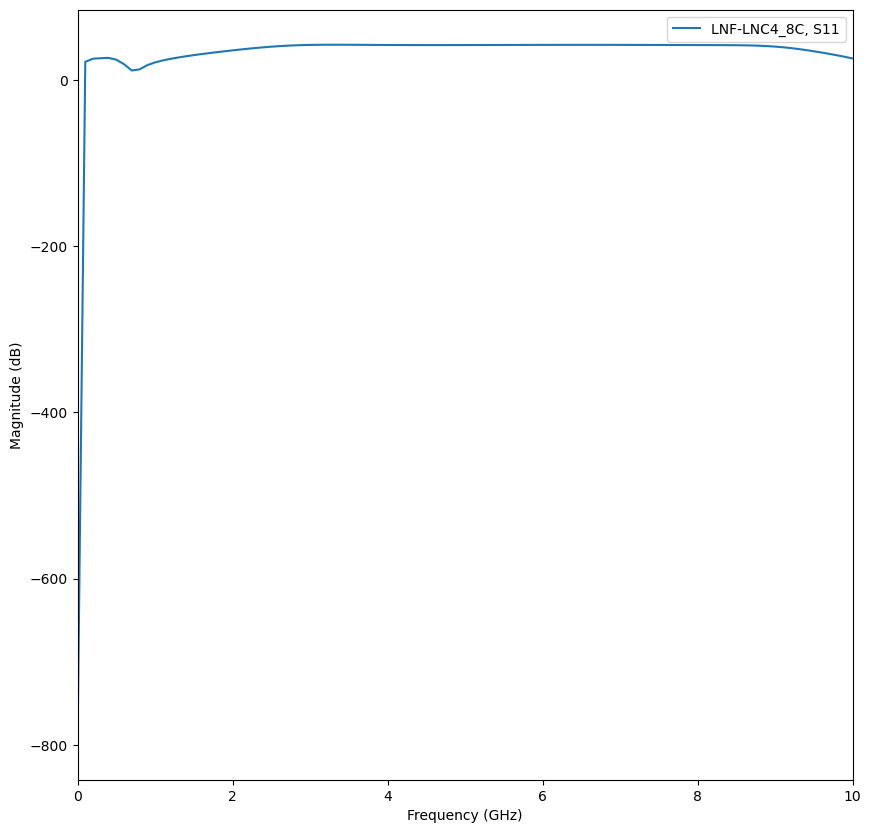

In [32]:
bjt.s21.plot_s_db()


Let's plot the smith chart for it:

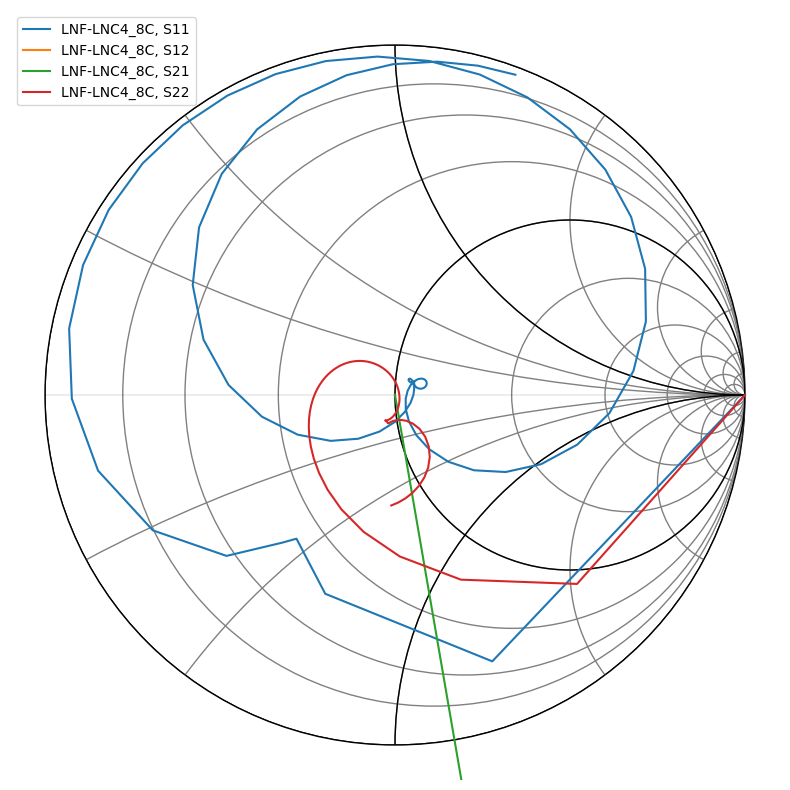

In [21]:
bjt.plot_s_smith()

Now let's calculate the source and load stablity curves.
I'm slightly misusing the `Network` type to plot the curves; normally the curves you pass in to `Network` should be a function of frequency, but it also works to draw these circles as long as you don't try to use any other functions on them

In [22]:
sqabs = lambda x: np.square(np.absolute(x))

delta = bjt.s11.s*bjt.s22.s - bjt.s12.s*bjt.s21.s
rl = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s22.s) - sqabs(delta)))
cl = np.conj(bjt.s22.s - delta*np.conj(bjt.s11.s))/(sqabs(bjt.s22.s) - sqabs(delta))

rs = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s11.s) - sqabs(delta)))
cs = np.conj(bjt.s11.s - delta*np.conj(bjt.s22.s))/(sqabs(bjt.s11.s) - sqabs(delta))

def calc_circle(c, r):
    theta = np.linspace(0, 2*np.pi, 1000)
    return c + r*np.exp(1.0j*theta)

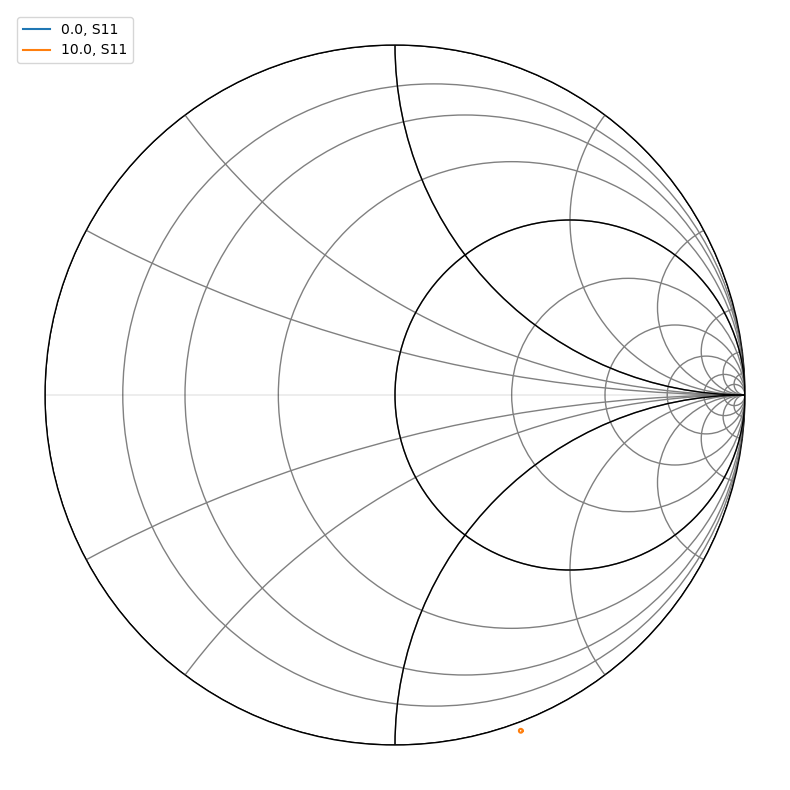

In [23]:
for i, f in enumerate(bjt.f):
    # decimate it a little
    if i % 100 != 0:
        continue
    n = net.Network(name=str(f/1.e+9), s=calc_circle(cs[i][0, 0], rs[i][0, 0]))
    n.plot_s_smith()

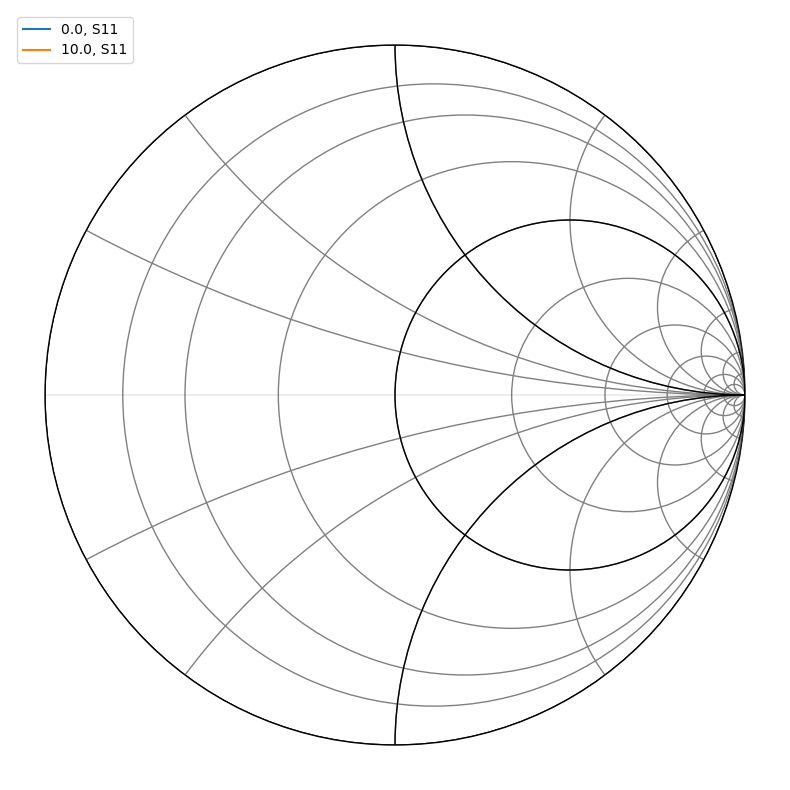

In [24]:
for i, f in enumerate(bjt.f):
    # decimate it a little
    if i % 100 != 0:
        continue
    n = net.Network(name=str(f/1.e+9), s=calc_circle(cl[i][0, 0], rl[i][0, 0]))
    n.plot_s_smith()

So we can see that we need to avoid inductive loads near short circuit in the input matching network and high impedance inductive loads on the output.

Let's draw some constant noise circles. First we grab the noise parameters for our target frequency from the network model:

the optimum source reflection coefficient is  (-0.9011061255119979-0.1635888025082026j)


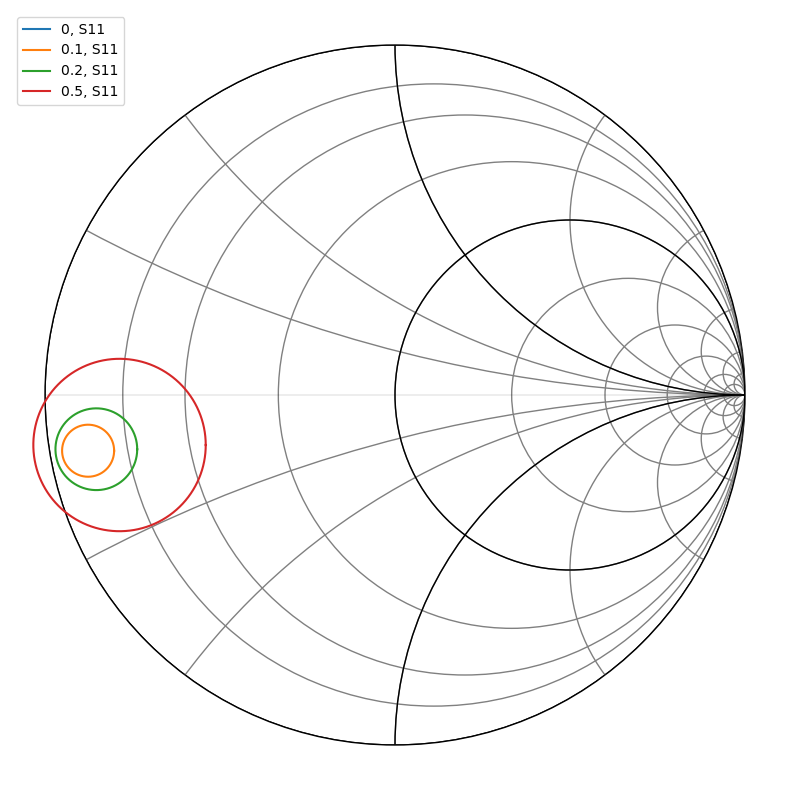

In [25]:
idx_915mhz = skrf.util.find_nearest_index(bjt.f, 915.e+6)

# we need the normalized equivalent noise and optimum source coefficient to calculate the constant noise circles
rn = bjt.rn[idx_915mhz]/50
gamma_opt = bjt.g_opt[idx_915mhz]
fmin = bjt.nfmin[idx_915mhz]

for nf_added in [0, 0.1, 0.2, 0.5]:
    nf = 10**(nf_added/10) * fmin
    
    N = (nf - fmin)*abs(1+gamma_opt)**2/(4*rn)
    c_n = gamma_opt/(1+N)
    r_n = 1/(1-N)*np.sqrt(N**2 + N*(1-abs(gamma_opt)**2))
    
    n = net.Network(name=str(nf_added), s=calc_circle(c_n, r_n))
    n.plot_s_smith()

print("the optimum source reflection coefficient is ", gamma_opt)

So we can see from the chart that just leaving the input at 50 ohms gets us under 0.1 dB of extra noise, which seems pretty good. I'm actually not sure that these actually correspond to the noise figure level increments I have listed up there, but the circles should at least correspond to increasing noise figures

So let's leave the input at 50 ohms and figure out how to match the output network to maximize gain and stability. Let's see what matching the load impedance with an unmatched input gives us:

In [26]:
gamma_s = 0.0

gamma_l = np.conj(bjt.s22.s - bjt.s21.s*gamma_s*bjt.s12.s/(1-bjt.s11.s*gamma_s))
gamma_l = gamma_l[idx_915mhz, 0, 0]
is_gamma_l_stable = np.absolute(gamma_l - cl[idx_915mhz]) > rl[idx_915mhz]

gamma_l, is_gamma_l_stable

((-0.24049574300949092+0.14746508354769516j), array([[ True]]))

This looks like it may be kind of close to the load instability circles, so it might make sense to pick a load point with less gain for more stability, or to pick a different source impedance with more noise.

But for now let's just build a matching network for this and see how it performs:

In [27]:
def calc_matching_network_vals(z1, z2):
    flipped = np.real(z1) < np.real(z2)
    if flipped:
        z2, z1 = z1, z2
        
    # cancel out the imaginary parts of both input and output impedances    
    z1_par = 0.0
    if abs(np.imag(z1)) > 1e-6:
        # parallel something to cancel out the imaginary part of
        # z1's impedance
        z1_par = 1/(-1j*np.imag(1/z1))
        z1 = 1/(1./z1 + 1/z1_par)
    z2_ser = 0.0
    if abs(np.imag(z2)) > 1e-6:
        z2_ser = -1j*np.imag(z2)
        z2 = z2 + z2_ser
        
    Q = np.sqrt((np.real(z1) - np.real(z2))/np.real(z2))
    x1 = -1.j * np.real(z1)/Q
    x2 = 1.j * np.real(z2)*Q
    
    x1_tot = 1/(1/z1_par + 1/x1)
    x2_tot = z2_ser + x2
    if flipped:
        return x2_tot, x1_tot
    else:
        return x1_tot, x2_tot

z_l = net.s2z(np.array([[[gamma_l]]]))[0,0,0]
# note that we're matching against the conjugate;
# this is because we want to see z_l from the BJT side
# if we plugged in z the matching network would make
# the 50 ohms look like np.conj(z) to match against it, so
# we use np.conj(z_l) so that it'll look like z_l from the BJT's side
z_par, z_ser = calc_matching_network_vals(np.conj(z_l), 50)
z_l, z_par, z_ser

ZeroDivisionError: float division by zero

Let's calculate what the component values are:

In [28]:
c_par = np.real(1/(2j*np.pi*915e+6*z_par))
l_ser = np.real(z_ser/(2j*np.pi*915e+6))

c_par, l_ser

NameError: name 'z_par' is not defined

The capacitance is kind of low but the inductance seems reasonable. Let's test it out:

In [29]:
output_network = tem.shunt_capacitor(c_par) ** tem.inductor(l_ser)

amplifier = bjt ** output_network

amplifier.plot_s_smith()

NameError: name 'c_par' is not defined

That looks pretty reasonable; let's take a look at the S21 to see what we got:

In [30]:
amplifier.s21.plot_s_db()

NameError: name 'amplifier' is not defined

So about 18 dB gain; let's see what our noise figure is:

In [31]:
10*np.log10(amplifier.nf(50.)[idx_915mhz])

NameError: name 'amplifier' is not defined

So 0.96 dB NF, which is reasonably close to the BJT tombstone optimal NF of 0.95 dB